In [ ]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install jax
!pip install jaxlib
!pip install git+https://github.com/professorwug/diffusion-curvature
!pip install pygsp
!pip install graphtools
!pip install tqdm
!pip install nbdev

  Cloning https://github.com/professorwug/diffusion-curvature to /tmp/pip-req-build-p9gum1bu
  Running command git clone --filter=blob:none --quiet https://github.com/professorwug/diffusion-curvature /tmp/pip-req-build-p9gum1bu
  Resolved https://github.com/professorwug/diffusion-curvature to commit 1834e35d50ebbbb1f49f89c30c69f5b5d48199c7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from diffusion_curvature.core import DiffusionCurvature

In [ ]:
#Hyperparameters and model
batch_size = 128
num_epochs = 20
learning_rate = 0.01
dim_value = 16
output_directory = "./outputs"
os.makedirs(output_directory, exist_ok = True)
device = ("cuda" if torch.cuda.is_available() else "cpu")

class SimpleMLP(nn.Module):
  def __init__(self, num_classes=10):
    super(SimpleMLP, self).__init__()
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, dim_value),
        nn.ReLU(),
        nn.Linear(dim_value, num_classes)
        )

  def forward(self, x):
    x = self.flatten(x)
    output = self.layers(x)
    return output

In [ ]:
#import datasets and initalize dataloader
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))])
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)

In [ ]:
# model initialization

model = SimpleMLP(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# A python hook to store stuff about penultimate embeddings
penultimate_embeddings = []
def hook_fn(module, input, output):
    # output shape: (batch_size, 256)
    embedding = output.detach().cpu().numpy()
    penultimate_embeddings.append(embedding)

hook = model.layers[2].register_forward_hook(hook_fn)

#Diffusion Curvature

Diff_curv = DiffusionCurvature(estimate_local_dimension=False)

In [ ]:
# Training the model and getting embeddings

def train():
  for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss/len(train_loader)
    print(f"The loss in epoch {epoch} is {epoch_loss}. ")

    penultimate_embeddings.clear()
    model.eval()
    with torch.no_grad():
            for images, _ in train_loader:
                images = images.to(device)
                _ = model(images)
    ebdgs = np.concatenate(penultimate_embeddings, axis=0)
    idx = np.random.choice(ebdgs.shape[0], 2000, replace=False)
    np.save(os.path.join(output_directory, f"feats_epoch_{epoch}_curv_dim{dim_value}.npy"), ebdgs)
    print(f"Saved penultimate embeddings shape: {ebdgs.shape}")
    curv = Diff_curv.fit_transform(X=ebdgs[idx], locality_scale=0.1, graph_knn=30)
    print(f"Curvature (epoch {epoch}) -> mean: {curv.mean():.4f}, std: {curv.std():.4f}")
    np.save(os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy"), curv)

train()

The loss in epoch 1 is 61.168332367309375. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 1) -> mean: 0.3273, std: 1.0418
The loss in epoch 2 is 20.71397917865436. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 2) -> mean: 0.2627, std: 1.0529
The loss in epoch 3 is 13.859659100900581. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 3) -> mean: 0.2203, std: 1.0745
The loss in epoch 4 is 10.373396721475922. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 4) -> mean: 0.1111, std: 1.1014
The loss in epoch 5 is 8.124728100386255. 
Saved penultimate embeddings shape: (60000, 16)
Estimated dimension(s) in point cloud: {8}
Curvature (epoch 5) -> mean: 0.4434, std: 1.0792
The loss in epoch 6 is 6.634451299588055. 
Saved penultimate embeddings shape: (60

Epoch 1: Mean = 0.1450, Median = 0.6004, Std = 1.1393
Epoch 2: Mean = 0.5066, Median = 0.9647, Std = 1.1900
Epoch 3: Mean = 0.2920, Median = 0.7403, Std = 1.1510
Epoch 4: Mean = 0.1321, Median = 0.6041, Std = 1.2120
Epoch 5: Mean = 0.5098, Median = 0.9699, Std = 1.1849
Epoch 6: Mean = 0.4461, Median = 0.9045, Std = 1.2071
Epoch 7: Mean = 0.2504, Median = 0.6525, Std = 1.1246
Epoch 8: Mean = 0.3070, Median = 0.7839, Std = 1.2041
Epoch 9: Mean = 0.3225, Median = 0.7615, Std = 1.1616
Epoch 10: Mean = 0.3326, Median = 0.7541, Std = 1.1431
Epoch 11: Mean = 0.1905, Median = 0.6163, Std = 1.1737
Epoch 12: Mean = 0.1926, Median = 0.5806, Std = 1.0655
Epoch 13: Mean = 0.2149, Median = 0.6361, Std = 1.1291
Epoch 14: Mean = 0.1800, Median = 0.6293, Std = 1.1659
Epoch 15: Mean = 0.3174, Median = 0.7219, Std = 1.1267
Epoch 16: Mean = 0.2709, Median = 0.6411, Std = 1.1128
Epoch 17: Mean = 0.2716, Median = 0.7000, Std = 1.1596
Epoch 18: Mean = 0.1363, Median = 0.5536, Std = 1.1496
Epoch 19: Mean = 0.

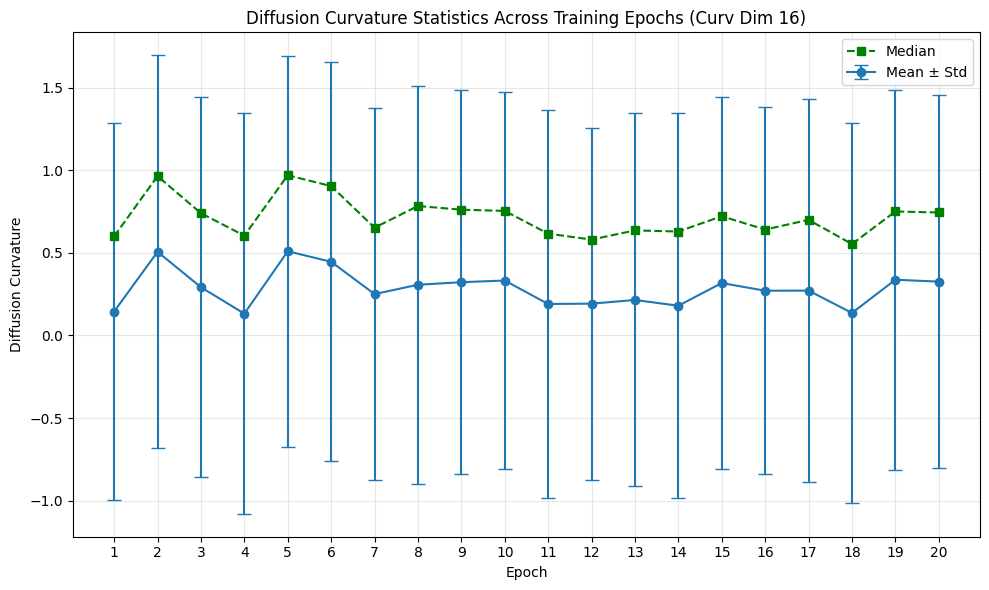

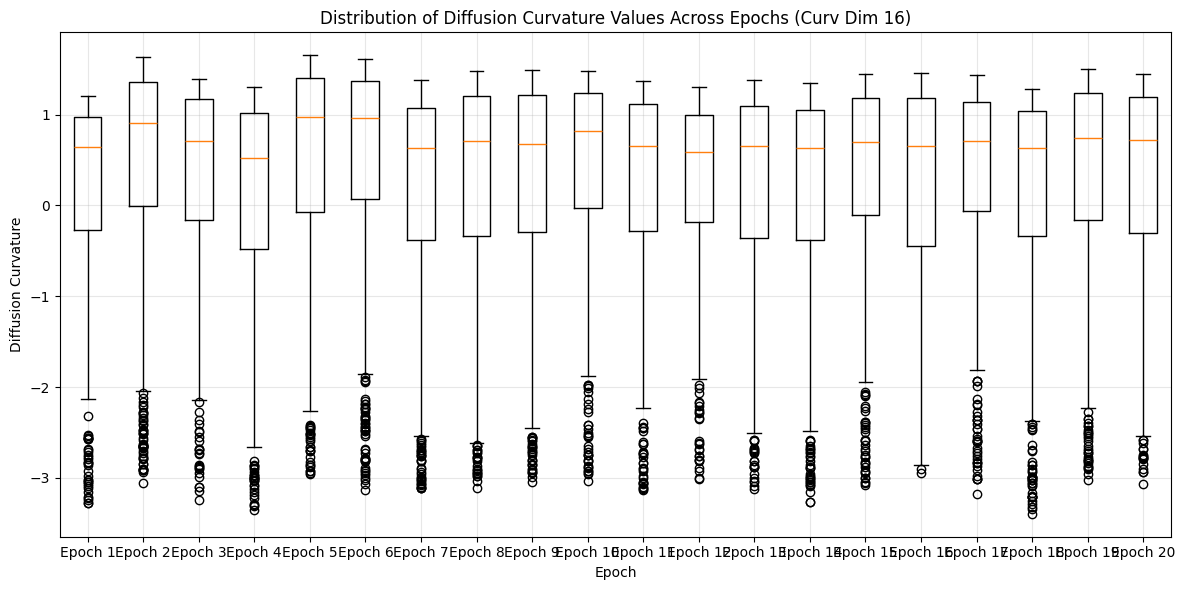

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os


plots_folder = "./curvature_plots"
os.makedirs(plots_folder, exist_ok = True)


curvature_stats = []
epoch_nums = []

for epoch in range(1, num_epochs + 1):
      # load curvatures
      curv_file = os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy")
      if os.path.exists(curv_file):
          curv = np.load(curv_file)

          mean_curv = np.mean(curv)
          median_curv = np.median(curv)
          std_curv = np.std(curv)

          # store stats
          curvature_stats.append({
              "epoch": epoch,
              "mean": mean_curv,
              "median": median_curv,
              "std": std_curv,
              "min": np.min(curv),
              "max": np.max(curv)
          })

          epoch_nums.append(epoch)
          print(f"Epoch {epoch}: Mean = {mean_curv:.4f}, Median = {median_curv:.4f}, Std = {std_curv:.4f}")
      else:
          print(f"curvature file for epoch {epoch} not found.")

# plot

plt.figure(figsize=(10, 6))

means = [stat["mean"] for stat in curvature_stats]
medians = [stat["median"] for stat in curvature_stats]
stds = [stat["std"] for stat in curvature_stats]

plt.errorbar(epoch_nums, means, yerr=stds, fmt='o-', label='Mean ± Std', capsize=5)
plt.plot(epoch_nums, medians, 's--', color='green', label='Median')

plt.xlabel('Epoch')
plt.ylabel('Diffusion Curvature')
plt.title(f'Diffusion Curvature Statistics Across Training Epochs (Curv Dim {dim_value})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(epoch_nums)
plt.tight_layout()

summary_plot_filename = os.path.join(plots_folder, f"curvature_summary_dim_{dim_value}.png")
plt.savefig(summary_plot_filename, dpi=300)
plt.show()

plt.figure(figsize=(12, 6))

boxplot_data = []
for epoch in epoch_nums:
    curv_file = os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy")
    curv = np.load(curv_file)

    if len(curv) > 500:
        idx = np.random.choice(len(curv), 500, replace=False)
        curv = curv[idx]

    boxplot_data.append(curv)

plt.boxplot(boxplot_data, labels=[f'Epoch {e}' for e in epoch_nums])
plt.xlabel('Epoch')
plt.ylabel('Diffusion Curvature')
plt.title(f'Distribution of Diffusion Curvature Values Across Epochs (Curv Dim {dim_value})')
plt.grid(True, alpha=0.3)
plt.tight_layout()

boxplot_filename = os.path.join(plots_folder, f"curvature_boxplot_dim_{dim_value}.png")
plt.savefig(boxplot_filename, dpi=300)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

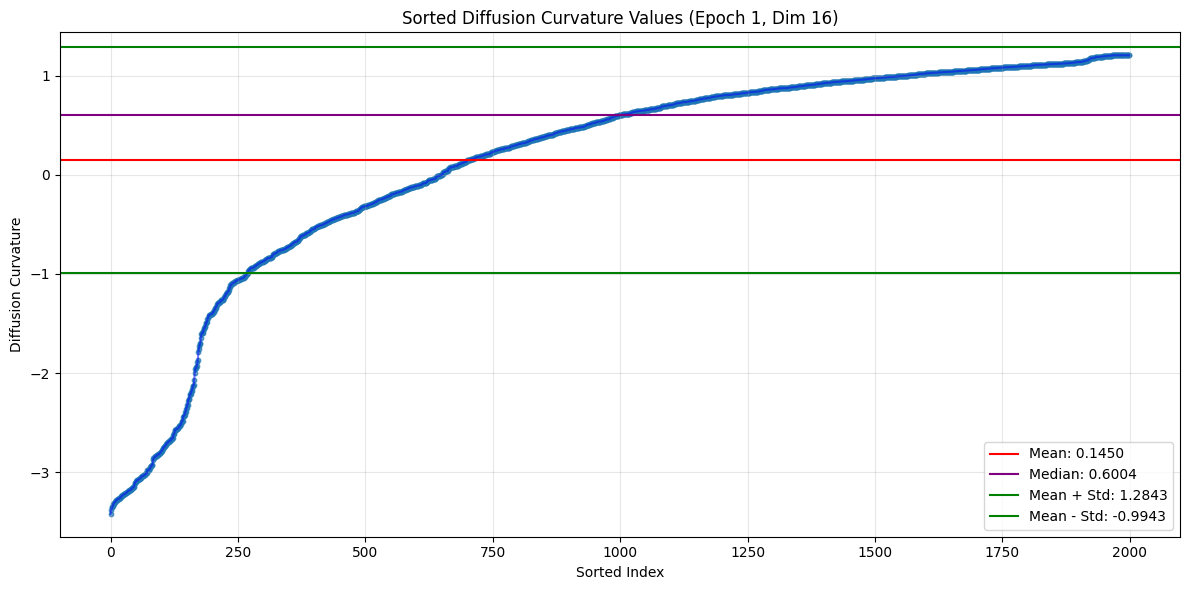


Epoch 1 Statistics:
Number of points: 2000
Mean curvature: 0.1450
Median curvature: 0.6004
Std deviation: 1.1393
Min curvature: -3.4201
Max curvature: 1.2059

Percentile analysis:
1th percentile: -3.2474
5th percentile: -2.7829
10th percentile: -1.3973
25th percentile: -0.3162
50th percentile: 0.6004
75th percentile: 0.9727
90th percentile: 1.0995
95th percentile: 1.1368
99th percentile: 1.2059


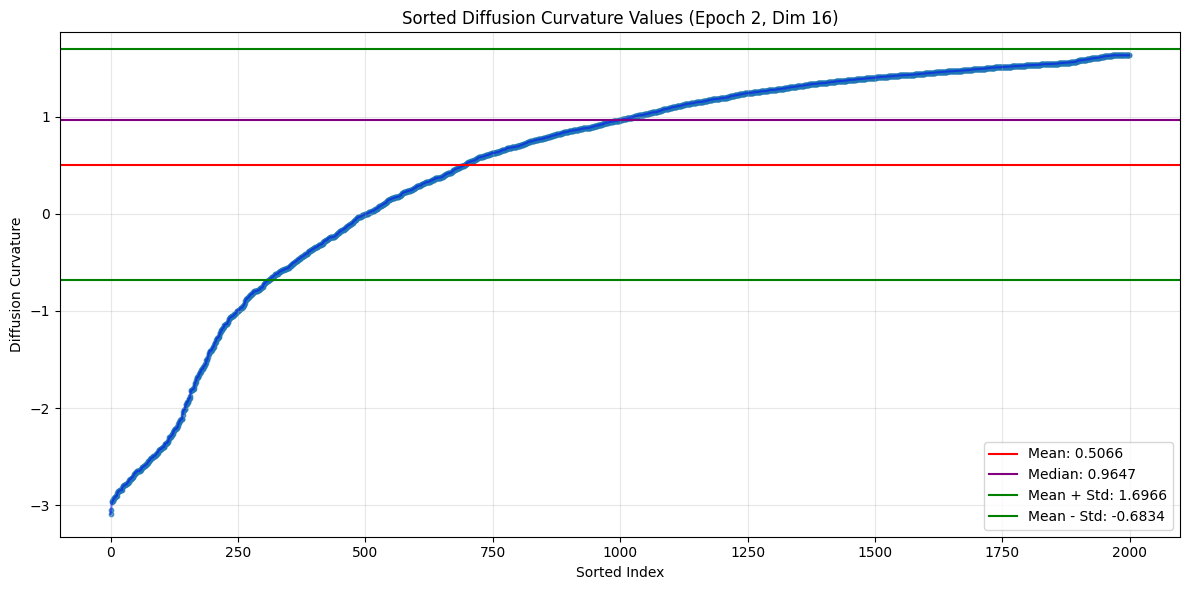


Epoch 2 Statistics:
Number of points: 2000
Mean curvature: 0.5066
Median curvature: 0.9647
Std deviation: 1.1900
Min curvature: -3.0887
Max curvature: 1.6322

Percentile analysis:
1th percentile: -2.8452
5th percentile: -2.4131
10th percentile: -1.3816
25th percentile: -0.0047
50th percentile: 0.9647
75th percentile: 1.4017
90th percentile: 1.5277
95th percentile: 1.5759
99th percentile: 1.6322


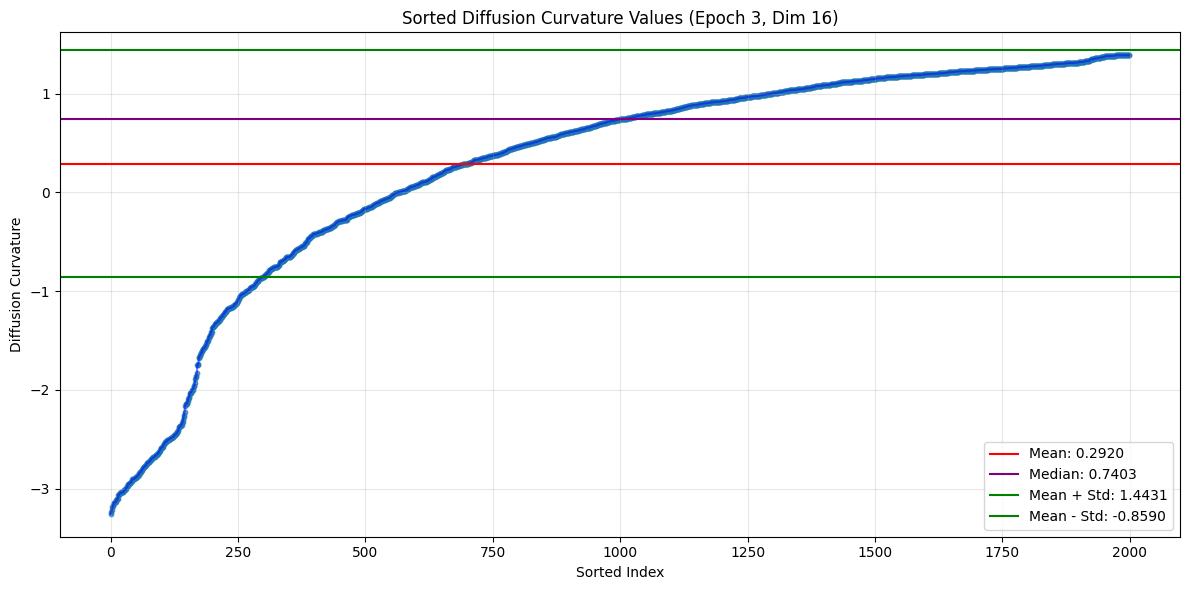


Epoch 3 Statistics:
Number of points: 2000
Mean curvature: 0.2920
Median curvature: 0.7403
Std deviation: 1.1510
Min curvature: -3.2558
Max curvature: 1.3906

Percentile analysis:
1th percentile: -3.0409
5th percentile: -2.5849
10th percentile: -1.3680
25th percentile: -0.1644
50th percentile: 0.7403
75th percentile: 1.1500
90th percentile: 1.2753
95th percentile: 1.3170
99th percentile: 1.3906


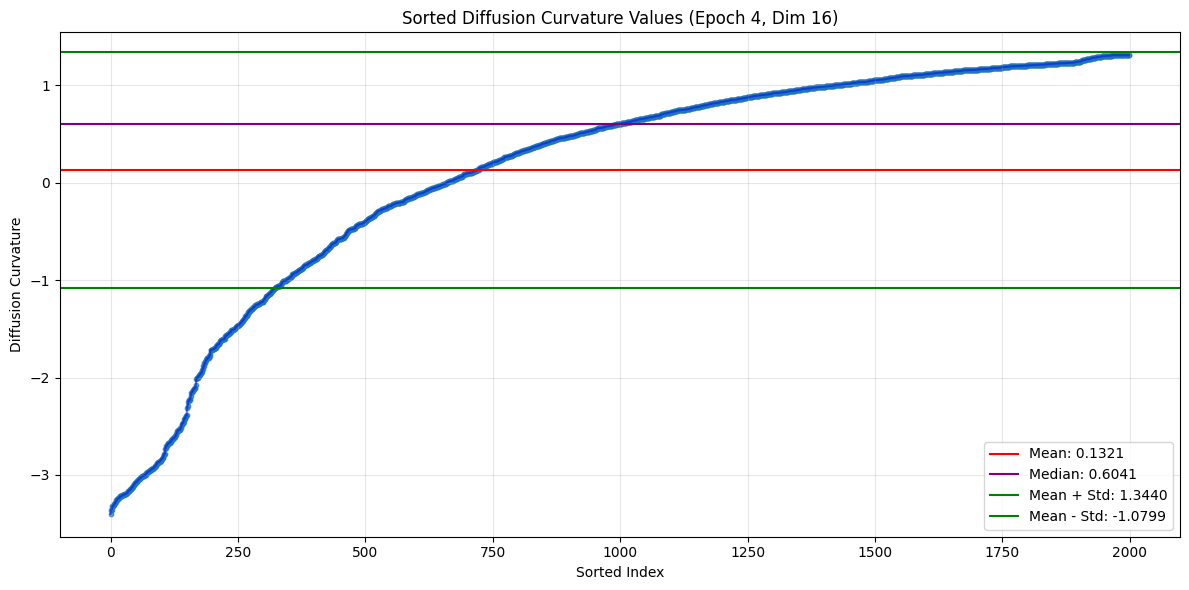


Epoch 4 Statistics:
Number of points: 2000
Mean curvature: 0.1321
Median curvature: 0.6041
Std deviation: 1.2120
Min curvature: -3.3986
Max curvature: 1.3067

Percentile analysis:
1th percentile: -3.2199
5th percentile: -2.8355
10th percentile: -1.7125
25th percentile: -0.4018
50th percentile: 0.6041
75th percentile: 1.0488
90th percentile: 1.2020
95th percentile: 1.2402
99th percentile: 1.3067


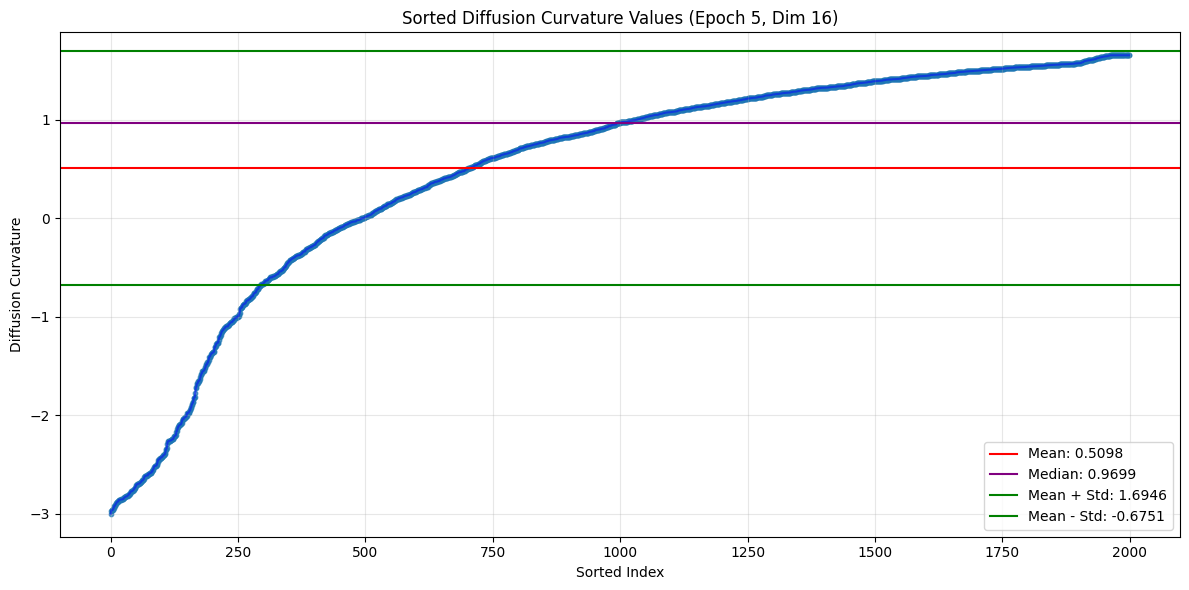


Epoch 5 Statistics:
Number of points: 2000
Mean curvature: 0.5098
Median curvature: 0.9699
Std deviation: 1.1849
Min curvature: -3.0029
Max curvature: 1.6542

Percentile analysis:
1th percentile: -2.8585
5th percentile: -2.4310
10th percentile: -1.3650
25th percentile: 0.0136
50th percentile: 0.9699
75th percentile: 1.3901
90th percentile: 1.5384
95th percentile: 1.5730
99th percentile: 1.6542


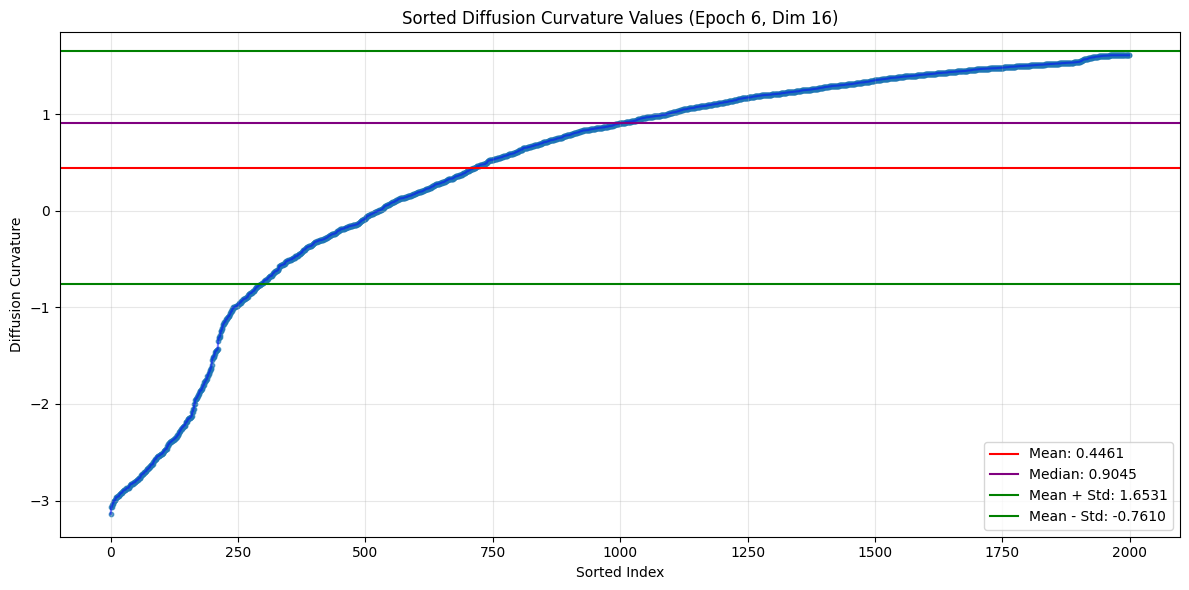


Epoch 6 Statistics:
Number of points: 2000
Mean curvature: 0.4461
Median curvature: 0.9045
Std deviation: 1.2071
Min curvature: -3.1376
Max curvature: 1.6100

Percentile analysis:
1th percentile: -2.9227
5th percentile: -2.5162
10th percentile: -1.5260
25th percentile: -0.0852
50th percentile: 0.9045
75th percentile: 1.3510
90th percentile: 1.5027
95th percentile: 1.5409
99th percentile: 1.6100


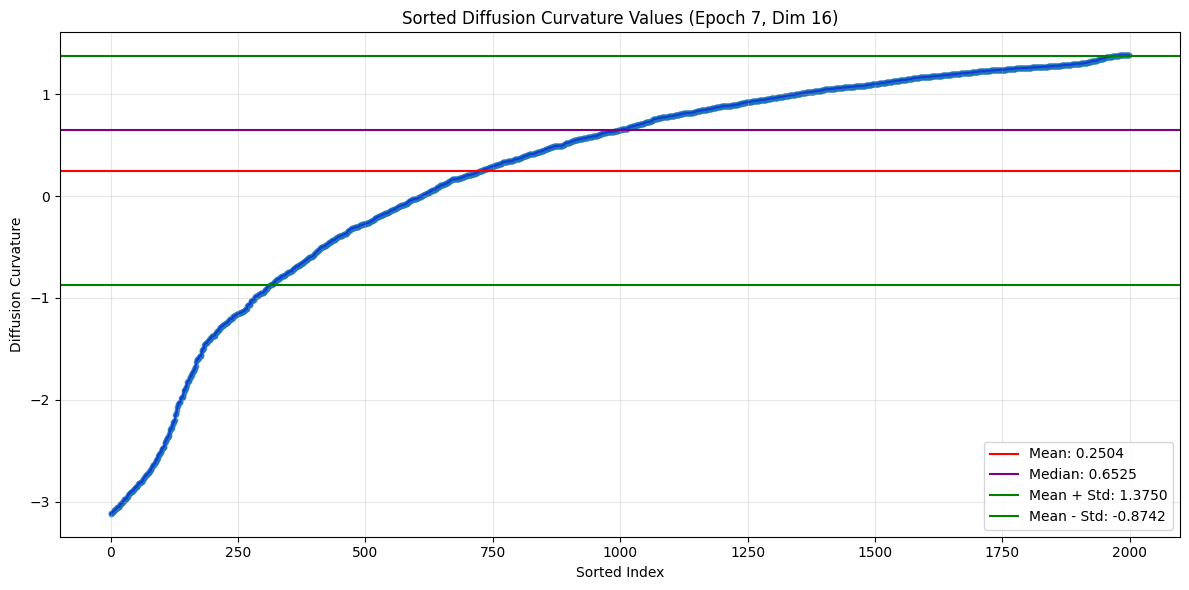


Epoch 7 Statistics:
Number of points: 2000
Mean curvature: 0.2504
Median curvature: 0.6525
Std deviation: 1.1246
Min curvature: -3.1202
Max curvature: 1.3845

Percentile analysis:
1th percentile: -3.0230
5th percentile: -2.4853
10th percentile: -1.3765
25th percentile: -0.2722
50th percentile: 0.6525
75th percentile: 1.1023
90th percentile: 1.2604
95th percentile: 1.3016
99th percentile: 1.3810


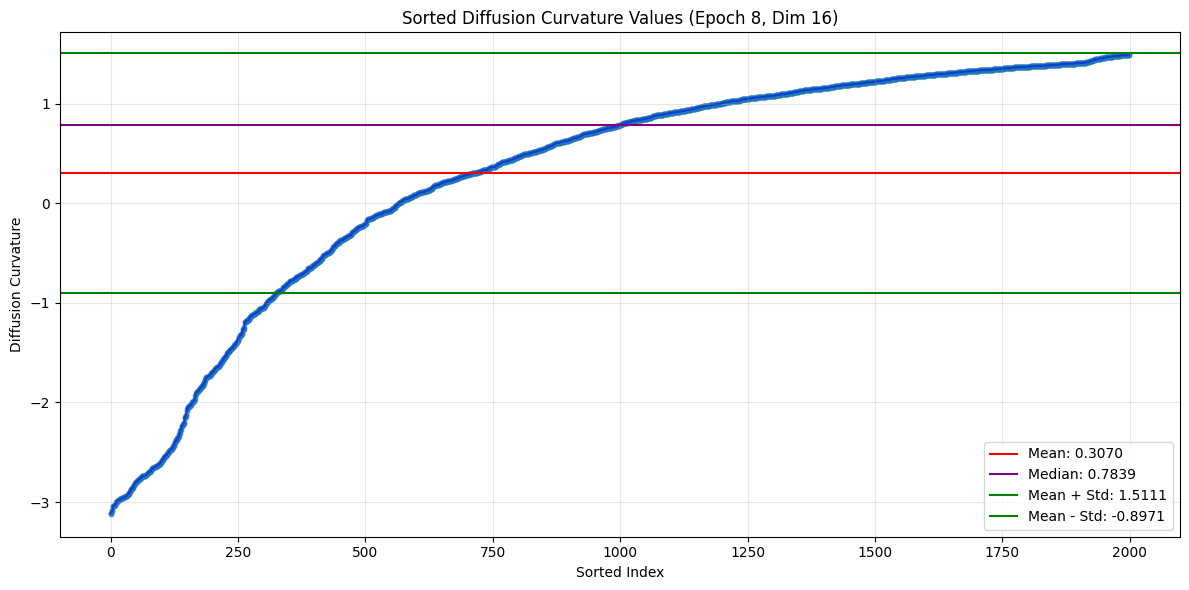


Epoch 8 Statistics:
Number of points: 2000
Mean curvature: 0.3070
Median curvature: 0.7839
Std deviation: 1.2041
Min curvature: -3.1168
Max curvature: 1.4841

Percentile analysis:
1th percentile: -2.9677
5th percentile: -2.5867
10th percentile: -1.6911
25th percentile: -0.2091
50th percentile: 0.7839
75th percentile: 1.2183
90th percentile: 1.3697
95th percentile: 1.4036
99th percentile: 1.4798


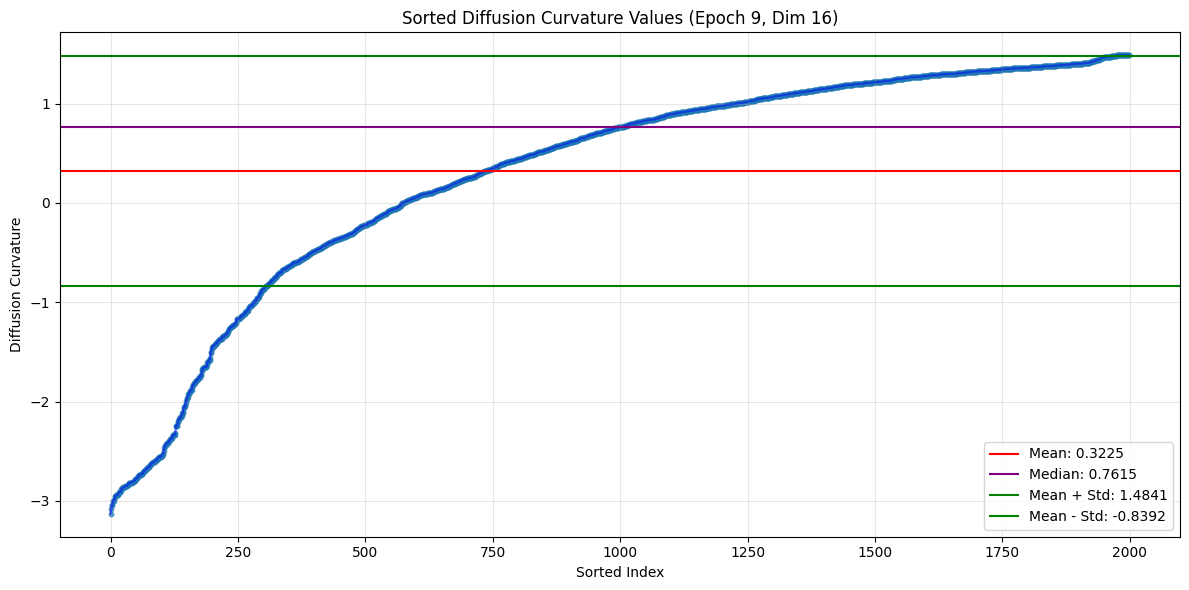


Epoch 9 Statistics:
Number of points: 2000
Mean curvature: 0.3225
Median curvature: 0.7615
Std deviation: 1.1616
Min curvature: -3.1294
Max curvature: 1.4867

Percentile analysis:
1th percentile: -2.9027
5th percentile: -2.5469
10th percentile: -1.4500
25th percentile: -0.2219
50th percentile: 0.7615
75th percentile: 1.2145
90th percentile: 1.3618
95th percentile: 1.4013
99th percentile: 1.4867


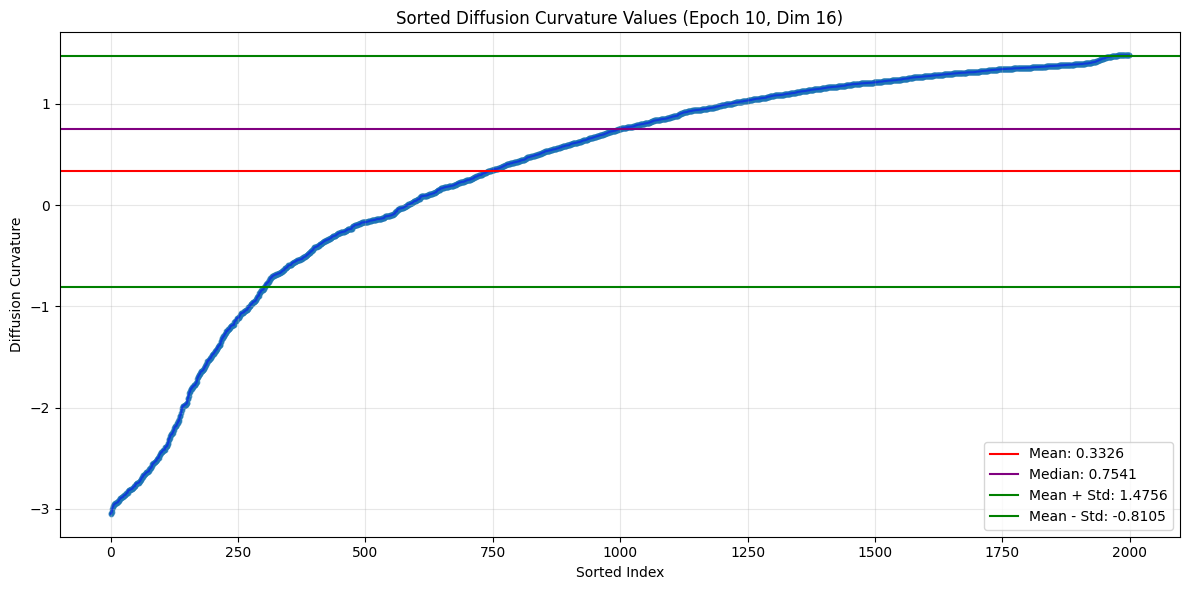


Epoch 10 Statistics:
Number of points: 2000
Mean curvature: 0.3326
Median curvature: 0.7541
Std deviation: 1.1431
Min curvature: -3.0489
Max curvature: 1.4793

Percentile analysis:
1th percentile: -2.8927
5th percentile: -2.4404
10th percentile: -1.4738
25th percentile: -0.1694
50th percentile: 0.7541
75th percentile: 1.2121
90th percentile: 1.3569
95th percentile: 1.3906
99th percentile: 1.4793


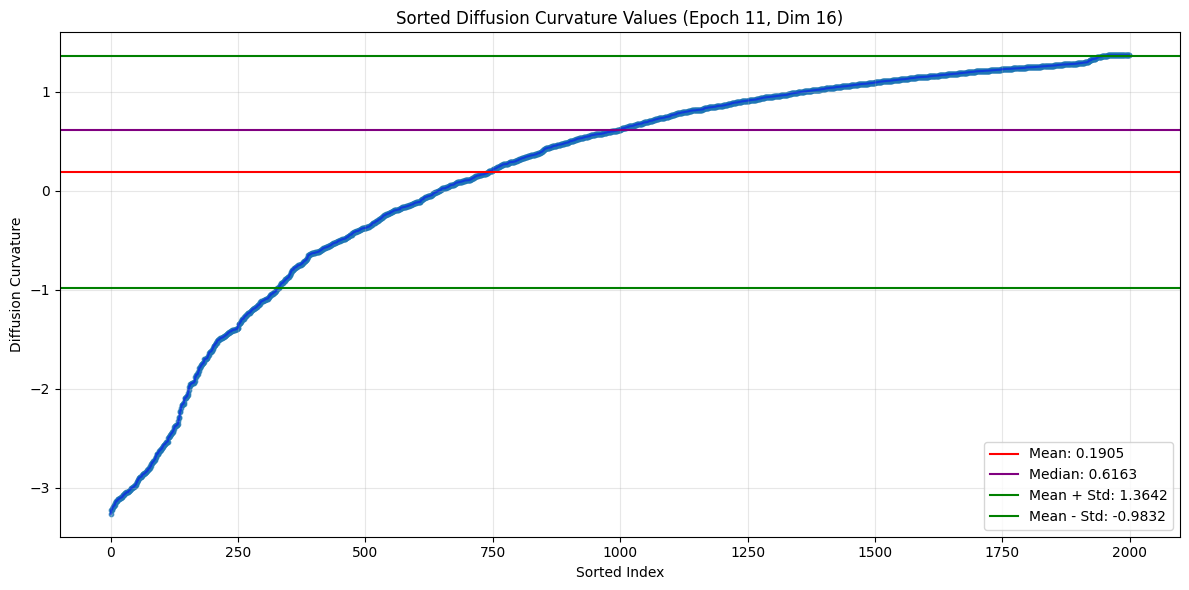


Epoch 11 Statistics:
Number of points: 2000
Mean curvature: 0.1905
Median curvature: 0.6163
Std deviation: 1.1737
Min curvature: -3.2658
Max curvature: 1.3693

Percentile analysis:
1th percentile: -3.1036
5th percentile: -2.6051
10th percentile: -1.5998
25th percentile: -0.3759
50th percentile: 0.6163
75th percentile: 1.0938
90th percentile: 1.2471
95th percentile: 1.2874
99th percentile: 1.3693


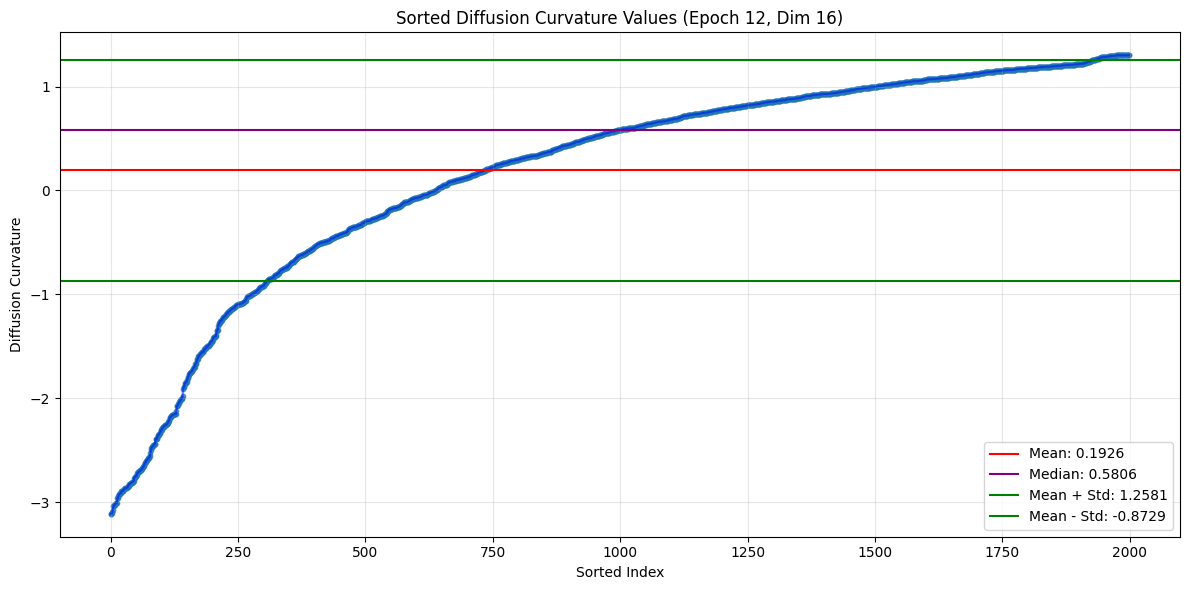


Epoch 12 Statistics:
Number of points: 2000
Mean curvature: 0.1926
Median curvature: 0.5806
Std deviation: 1.0655
Min curvature: -3.1115
Max curvature: 1.3006

Percentile analysis:
1th percentile: -2.9133
5th percentile: -2.3064
10th percentile: -1.4370
25th percentile: -0.3008
50th percentile: 0.5806
75th percentile: 0.9951
90th percentile: 1.1738
95th percentile: 1.2153
99th percentile: 1.3006


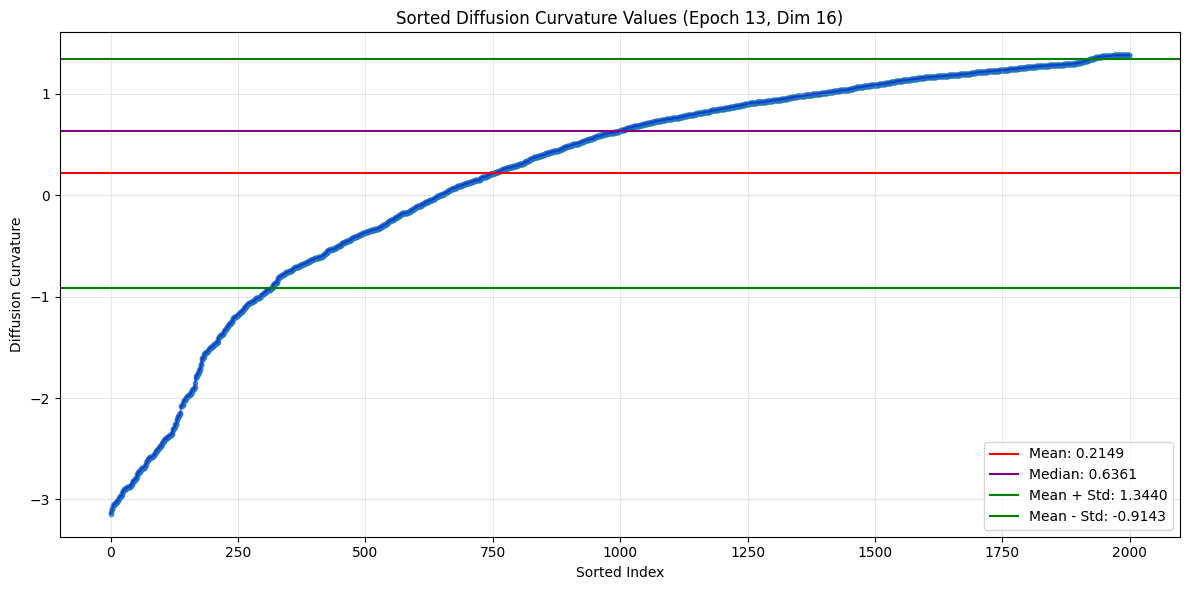


Epoch 13 Statistics:
Number of points: 2000
Mean curvature: 0.2149
Median curvature: 0.6361
Std deviation: 1.1291
Min curvature: -3.1420
Max curvature: 1.3807

Percentile analysis:
1th percentile: -2.9669
5th percentile: -2.4550
10th percentile: -1.4910
25th percentile: -0.3660
50th percentile: 0.6361
75th percentile: 1.0880
90th percentile: 1.2609
95th percentile: 1.3070
99th percentile: 1.3807


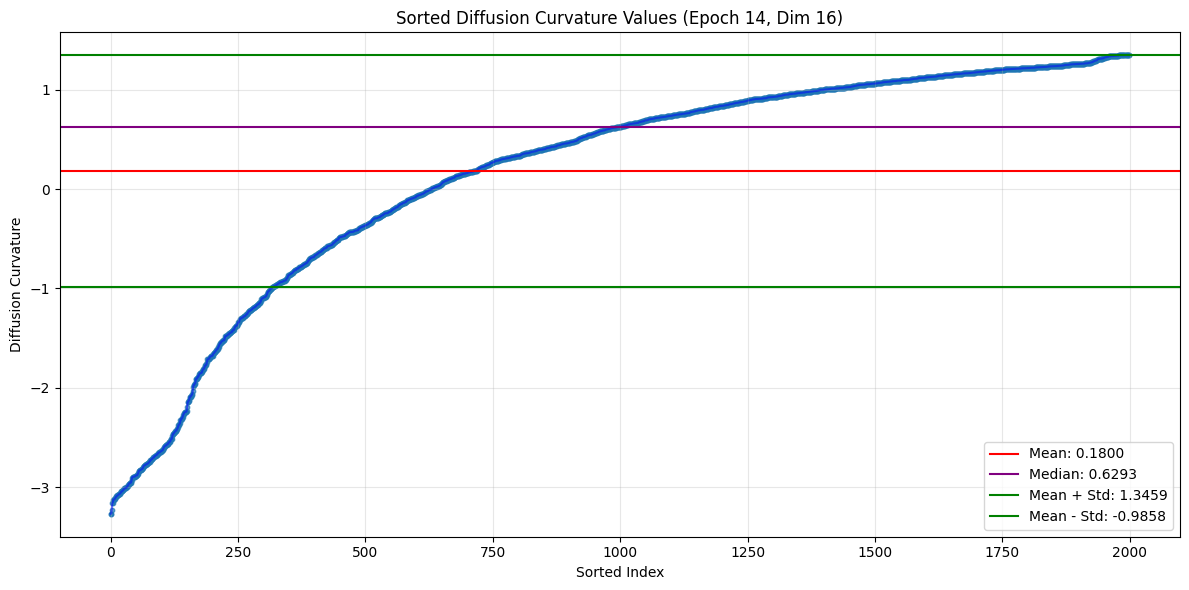


Epoch 14 Statistics:
Number of points: 2000
Mean curvature: 0.1800
Median curvature: 0.6293
Std deviation: 1.1659
Min curvature: -3.2698
Max curvature: 1.3482

Percentile analysis:
1th percentile: -3.0532
5th percentile: -2.6365
10th percentile: -1.6767
25th percentile: -0.3669
50th percentile: 0.6293
75th percentile: 1.0633
90th percentile: 1.2191
95th percentile: 1.2601
99th percentile: 1.3482


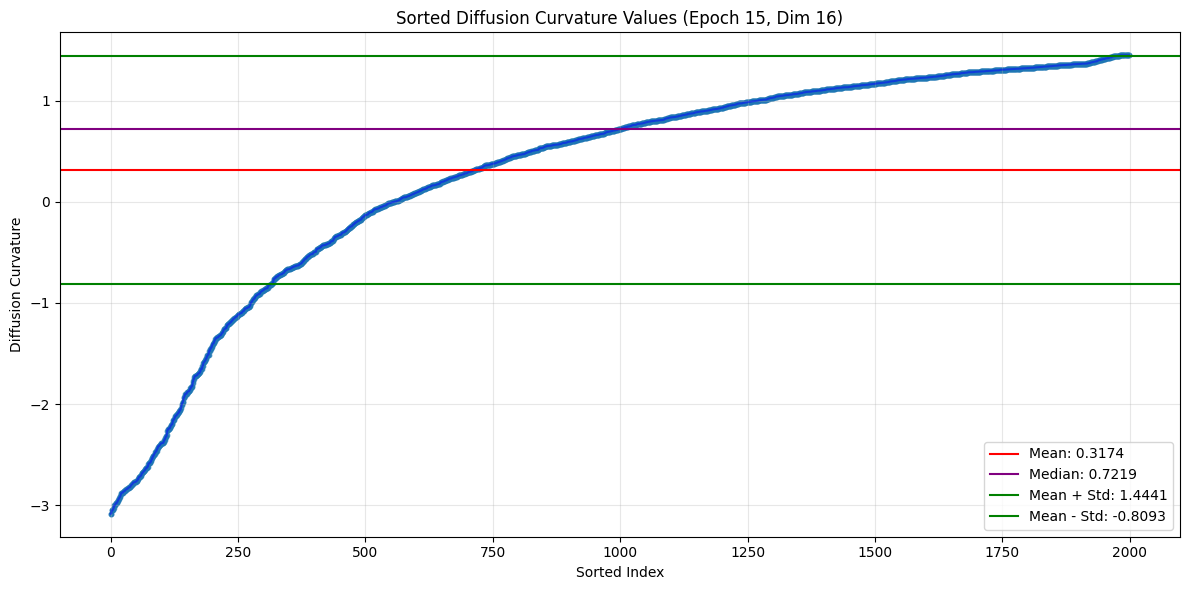


Epoch 15 Statistics:
Number of points: 2000
Mean curvature: 0.3174
Median curvature: 0.7219
Std deviation: 1.1267
Min curvature: -3.0862
Max curvature: 1.4506

Percentile analysis:
1th percentile: -2.8943
5th percentile: -2.3883
10th percentile: -1.4066
25th percentile: -0.1310
50th percentile: 0.7219
75th percentile: 1.1679
90th percentile: 1.3246
95th percentile: 1.3639
99th percentile: 1.4468


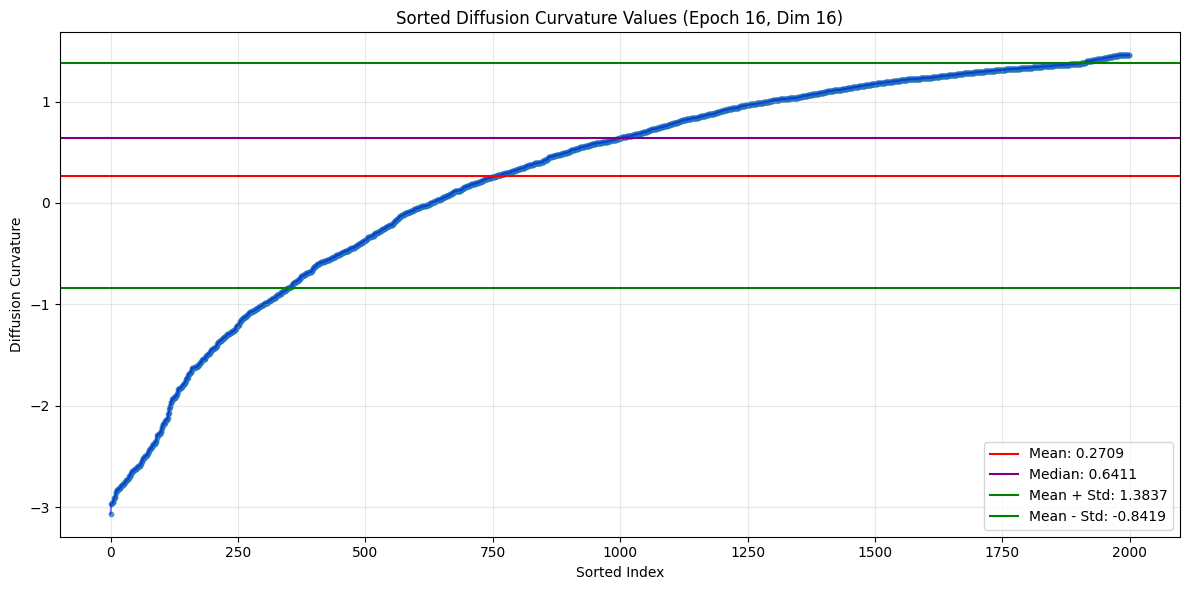


Epoch 16 Statistics:
Number of points: 2000
Mean curvature: 0.2709
Median curvature: 0.6411
Std deviation: 1.1128
Min curvature: -3.0645
Max curvature: 1.4566

Percentile analysis:
1th percentile: -2.7951
5th percentile: -2.2245
10th percentile: -1.4425
25th percentile: -0.3680
50th percentile: 0.6411
75th percentile: 1.1730
90th percentile: 1.3319
95th percentile: 1.3740
99th percentile: 1.4566


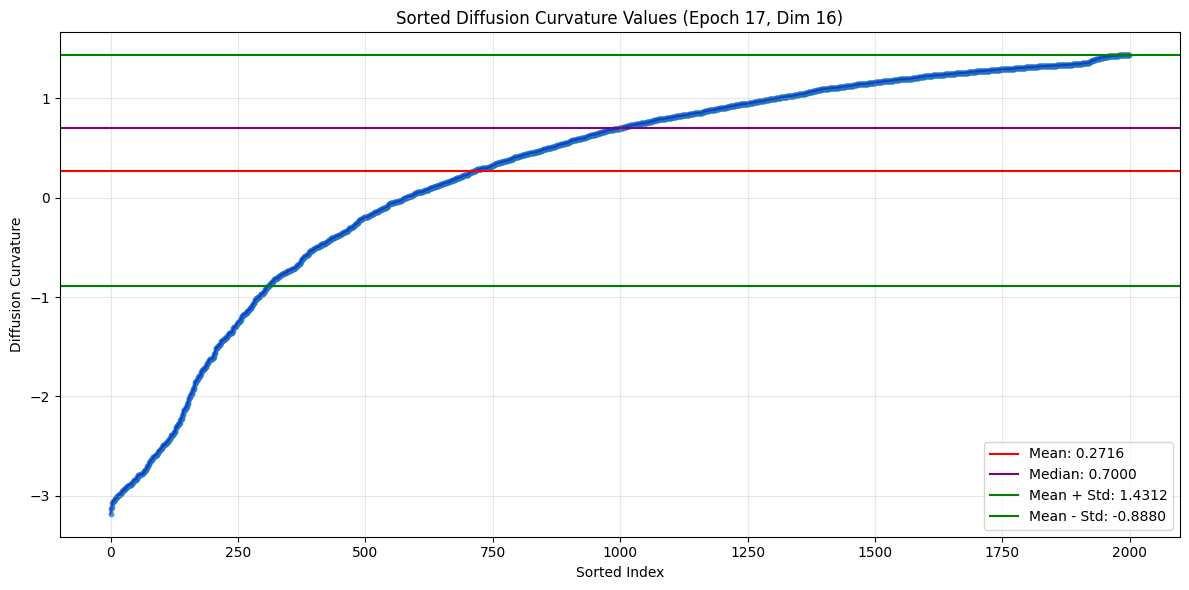


Epoch 17 Statistics:
Number of points: 2000
Mean curvature: 0.2716
Median curvature: 0.7000
Std deviation: 1.1596
Min curvature: -3.1815
Max curvature: 1.4331

Percentile analysis:
1th percentile: -2.9831
5th percentile: -2.5205
10th percentile: -1.6172
25th percentile: -0.1973
50th percentile: 0.7000
75th percentile: 1.1581
90th percentile: 1.3108
95th percentile: 1.3468
99th percentile: 1.4331


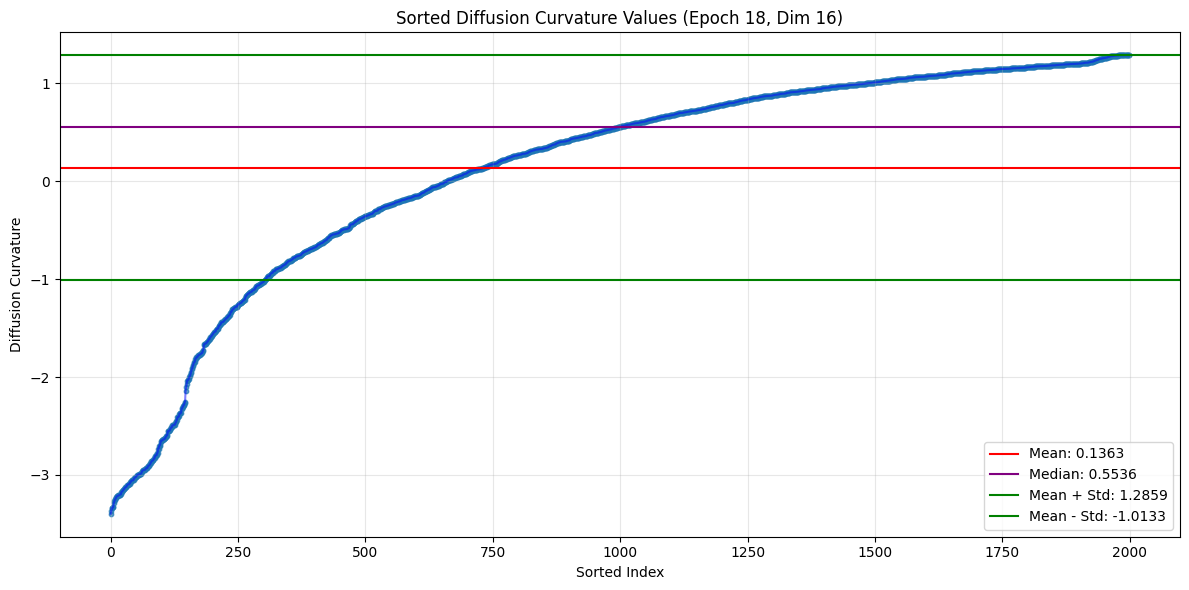


Epoch 18 Statistics:
Number of points: 2000
Mean curvature: 0.1363
Median curvature: 0.5536
Std deviation: 1.1496
Min curvature: -3.3960
Max curvature: 1.2846

Percentile analysis:
1th percentile: -3.1969
5th percentile: -2.6479
10th percentile: -1.5663
25th percentile: -0.3590
50th percentile: 0.5536
75th percentile: 1.0066
90th percentile: 1.1608
95th percentile: 1.1987
99th percentile: 1.2846


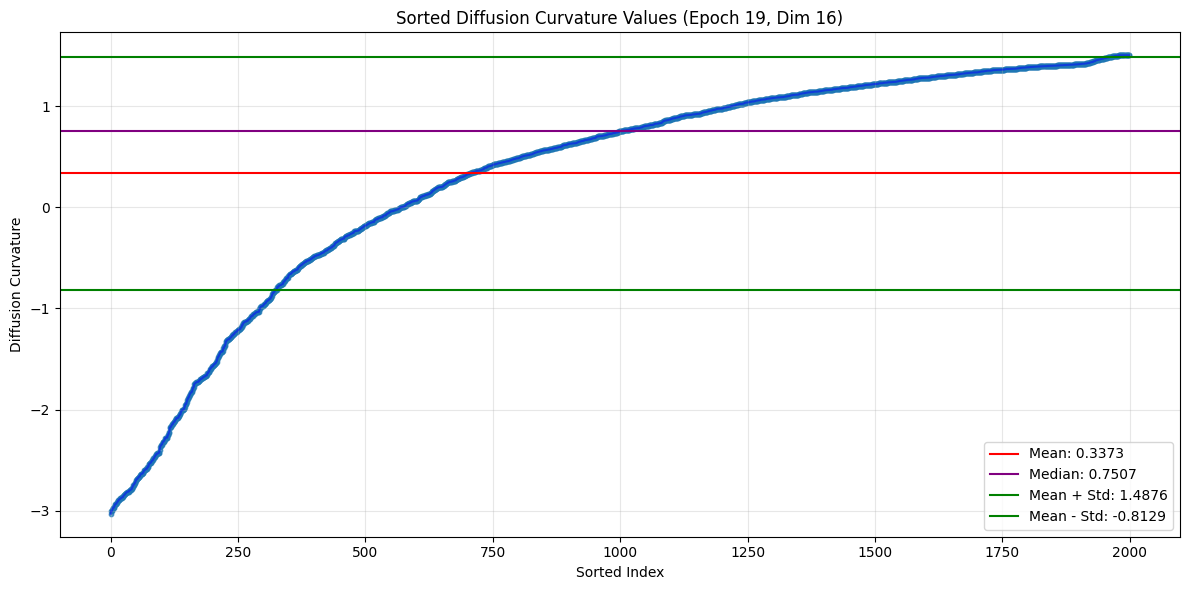


Epoch 19 Statistics:
Number of points: 2000
Mean curvature: 0.3373
Median curvature: 0.7507
Std deviation: 1.1503
Min curvature: -3.0291
Max curvature: 1.5023

Percentile analysis:
1th percentile: -2.8765
5th percentile: -2.3469
10th percentile: -1.5732
25th percentile: -0.1811
50th percentile: 0.7507
75th percentile: 1.2176
90th percentile: 1.3826
95th percentile: 1.4139
99th percentile: 1.5023


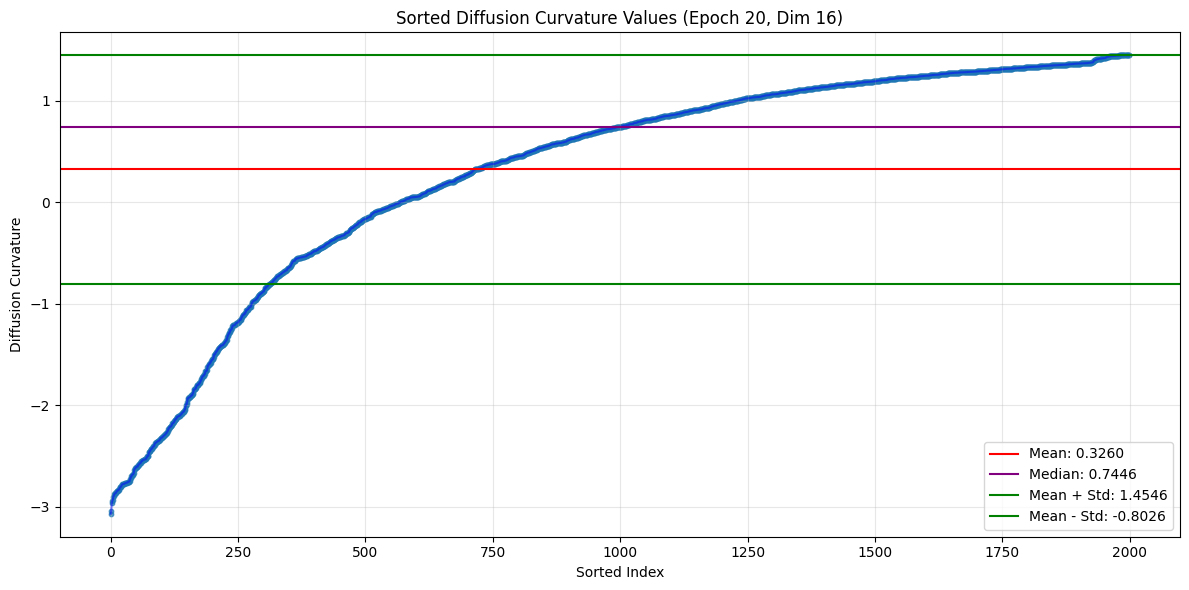


Epoch 20 Statistics:
Number of points: 2000
Mean curvature: 0.3260
Median curvature: 0.7446
Std deviation: 1.1286
Min curvature: -3.0719
Max curvature: 1.4505

Percentile analysis:
1th percentile: -2.8060
5th percentile: -2.3222
10th percentile: -1.5491
25th percentile: -0.1655
50th percentile: 0.7446
75th percentile: 1.1921
90th percentile: 1.3319
95th percentile: 1.3680
99th percentile: 1.4475


In [ ]:
for epoch in range(1, num_epochs + 1):
      curv_file = os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy")
      if os.path.exists(curv_file):
          curv = np.load(curv_file)

          sorted_indices = np.argsort(curv)
          sorted_curv = curv[sorted_indices]

          mean_curv = np.mean(curv)
          median_curv = np.median(curv)
          std_curv = np.std(curv)
          indices = np.arange(len(sorted_curv))

          plt.figure(figsize=(12, 6))
          plt.scatter(indices, sorted_curv, alpha=0.7, s=10)
          plt.plot(indices, sorted_curv, '-', alpha=0.5, color='blue')

          plt.axhline(y=mean_curv, color='r', linestyle='-', label=f'Mean: {mean_curv:.4f}')

          plt.axhline(y=median_curv, color='purple', linestyle='-', label=f'Median: {median_curv:.4f}')

          plt.axhline(y=mean_curv + std_curv, color='g', linestyle='-',
                     label=f'Mean + Std: {(mean_curv + std_curv):.4f}')
          plt.axhline(y=mean_curv - std_curv, color='g', linestyle='-',
                     label=f'Mean - Std: {(mean_curv - std_curv):.4f}')

          plt.xlabel('Sorted Index')
          plt.ylabel('Diffusion Curvature')
          plt.title(f'Sorted Diffusion Curvature Values (Epoch {epoch}, Dim {dim_value})')
          plt.legend()
          plt.grid(True, alpha=0.3)

          plt.tight_layout()

          # save and show plots
          plot_filename = os.path.join(plots_folder, f"curvature_plot_epoch_{epoch}_dim_{dim_value}.png")
          plt.savefig(plot_filename, dpi=300)
          plt.show()

          # print stats
          print(f"\nEpoch {epoch} Statistics:")
          print(f"Number of points: {len(curv)}")
          print(f"Mean curvature: {mean_curv:.4f}")
          print(f"Median curvature: {median_curv:.4f}")
          print(f"Std deviation: {std_curv:.4f}")
          print(f"Min curvature: {np.min(curv):.4f}")
          print(f"Max curvature: {np.max(curv):.4f}")

          # percentiles
          percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
          print("\nPercentile analysis:")
          for p in percentiles:
             p_value = np.percentile(curv, p)
             print(f"{p}th percentile: {p_value:.4f}")

      else:
          print(f"error - curvatures at {epoch} not found at {curv_file}")

In [ ]:
!zip -r /content/all_files.zip /content

from google.colab import files
files.download('/content/all_files.zip')

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.04.30/ (stored 0%)
  adding: content/.config/logs/2025.04.30/13.36.50.566118.log (deflated 58%)
  adding: content/.config/logs/2025.04.30/13.36.58.979052.log (deflated 86%)
  adding: content/.config/logs/2025.04.30/13.36.29.848398.log (deflated 93%)
  adding: content/.config/logs/2025.04.30/13.37.09.510583.log (deflated 56%)
  adding: content/.config/logs/2025.04.30/13.37.00.207659.log (deflated 58%)
  adding: content/.config/logs/2025.04.30/13.37.08.828246.log (deflated 57%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/hidd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>